#  Importando Drive (Caso for usar)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Instalando Bibliotecas

In [ ]:
pip install metpy

# Script

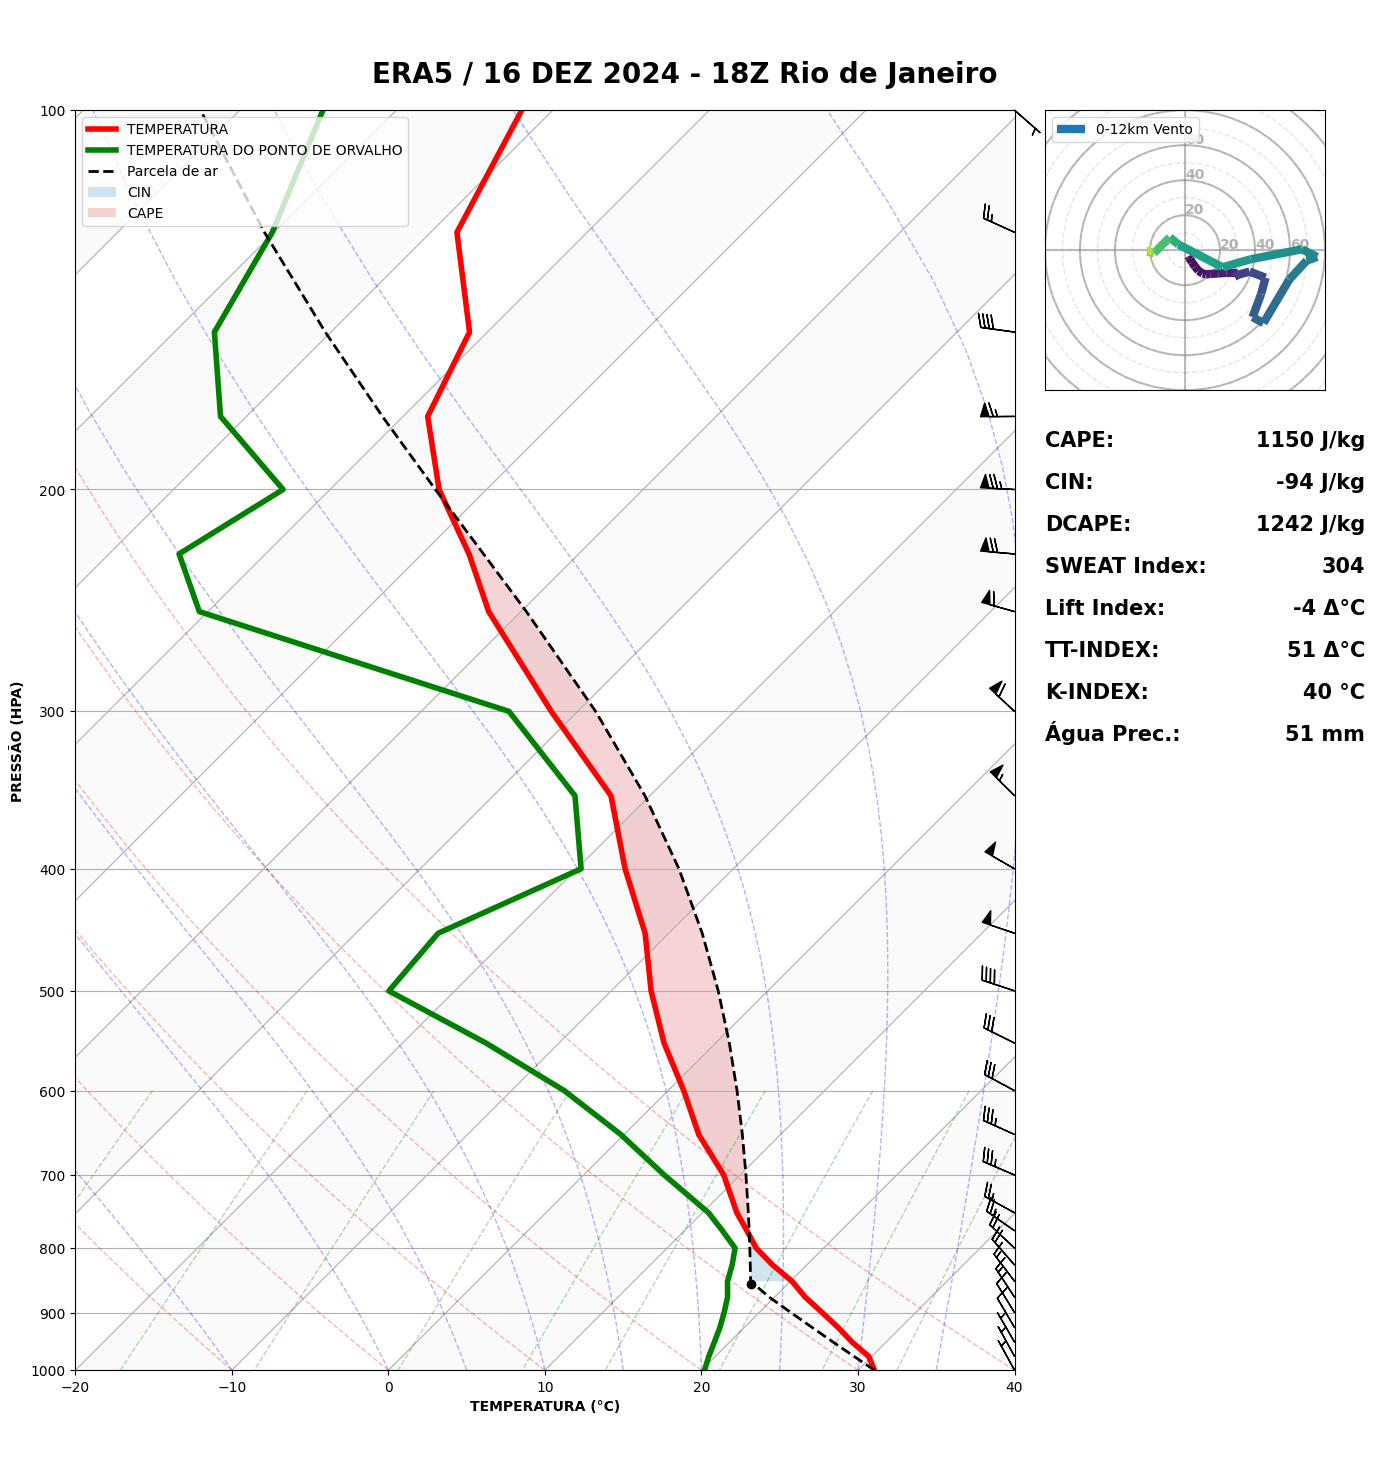

In [ ]:
# Importanto bibliotecas
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT, Hodograph
from metpy.units import units
import metpy.calc as mpcalc

# Abrir o NetCDF
ds = xr.open_dataset('/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/sounding.nc')

# Selecionando o ponto e o tempo
lat = -22.48
lon = -43.15
time = '2024-12-16T18:00'
profile = ds.sel(latitude=lat, longitude=lon, valid_time=time, method='nearest')

# Calculo Td
q = profile['q'].values * units('kg/kg')
T_k = profile['t'].values * units.kelvin
p = profile['pressure_level'].values * units.hPa
Td = mpcalc.dewpoint_from_specific_humidity(p, T_k, q).to('degC')

# Definindo variáveis
T = T_k.to('degC')
u_ms = profile['u'].values * units('m/s')
u = u_ms.to('knots')
v_ms = profile['v'].values * units('m/s')
v = v_ms.to('knots')
z = profile['z'].values * units.m
wind_speed = mpcalc.wind_speed(u, v)
wind_dir = mpcalc.wind_direction(u, v)

# Calculando NCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

# Calculando Indices Termodinâmicos
cape, cin = mpcalc.cape_cin(p, T, Td, prof)
dcape, dcape_pressures, dcape_temperatures = mpcalc.downdraft_cape(p, T, Td)
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
sweat_index = mpcalc.sweat_index(p, T, Td, wind_speed, wind_dir)
sweat = sweat_index.item()
lift_index = mpcalc.lifted_index(p, T, prof)
li = lift_index.item()
pw = mpcalc.precipitable_water(p, Td)

# Plotando a Figura
fig = plt.figure(figsize=(20, 14))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.50, 0.90))

# Ajustar limites dos eixos, nomes e cor
skew.ax.set_ylim(1000, 100) # Pressão
skew.ax.set_xlim(-20, 40) # Temperatura
skew.ax.set_xlabel(str.upper(f'Temperatura ({T.units:~P})'), weight='bold')
skew.ax.set_ylabel(str.upper(f'Pressão ({p.units:~P})'), weight='bold')
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Plot das linhas do Skew-T
skew.plot_dry_adiabats(lw=1, alpha=0.3) # Adiabática seca
skew.plot_moist_adiabats(lw=1, alpha=0.3) # Adiabática saturada
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Plotando linhas de T e Td e barbelas
skew.plot(p, T, 'r', lw=4, label='TEMPERATURA')
skew.plot(p, Td, 'g', lw=4, label='TEMPERATURA DO PONTO DE ORVALHO')
skew.plot_barbs(p, u, v)

# Utilizar apenas quando as barbabelas estiverem em intervalos irregulares, caso queria suavizar o gráfico
#interval = np.logspace(2, 3, 40) * units.hPa
#idx = mpcalc.resample_nn_1d(p, interval)
#skew.plot_barbs(pressure=p[idx], u=u[idx].to('knots'), v=v[idx].to('knots'))

# Plotando NCL e perfil da parcela
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
skew.plot(p, prof, 'k', linewidth=2, linestyle='--', label='Parcela de ar')

# Plotando CAPE e CIN no Skew-T
skew.shade_cin(p, T, prof, Td, alpha=0.2, label='CIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='CAPE')

# Plotando Hodógrafa
hodo_ax = plt.axes((0.52, 0.75, 0.20, 0.20))
h = Hodograph(hodo_ax, component_range=80.)
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')

# Grid hodógrafa
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)

# Adiciona valores nos eixos da hodógrafa
for i in range(20, 120, 20):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
for i in range(20, 120, 20):
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)


# Colocar Shaded alternando nas áreas das linhas de temperatura
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1000, 100]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.04, zorder=1)
h.plot_colormapped(u, v, c=z, linewidth=6, label='0-12km Vento')

# Plotando lista de índices
y = 0.71
indices_term = [
    ('CAPE:', cape, 'black'),
    ('CIN:', cin, 'black'),
    ('DCAPE:', dcape, 'black'),
    ('SWEAT Index:', sweat, 'black'),
    ('Lift Index:', li, 'black'),
    ('TT-INDEX:', total_totals, 'black'),
    ('K-INDEX:', kindex, 'black'),
    ('Água Prec.:', pw, 'black')]

for label, value, color in indices_term:
    plt.figtext(0.55, y, label, weight='bold', fontsize=15, color='black', ha='left')
    plt.figtext(0.71, y, f'{value:.0f~P}', weight='bold', fontsize=15, color=color, ha='right')
    y -= 0.03

# Adicionar legenda
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

plt.figtext(0.37, 0.97, 'ERA5 / 16 DEZ 2024 - 18Z Rio de Janeiro',
            weight='bold', fontsize=20, ha='center')

plt.savefig('/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/skewt_hodo_plot_18Z.png', dpi=300, bbox_inches='tight')

plt.show()


# Referências

https://unidata.github.io/MetPy/latest/examples/Advanced_Sounding_With_Complex_Layout.html#sphx-glr-examples-advanced-sounding-with-complex-layout-py